In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import pingouin as pg
import seaborn as sns
#sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from scipy import stats
from outliers import smirnov_grubbs as grubbs
import itertools
from pathlib import Path
from tqdm import tqdm_notebook
pd.options.display.max_columns = None
%cd _bio_eval

/media/data/DeepFLaSH/_bio_eval


## Choose Labs

In [2]:
LAB = 'wue'#, 'wue_02', 'mue']
CODER = ['ens_rohini','ens_manju','ens_dennis','ens_cora','ens_corinna']
ENS = ['ens_6', 'ens_7', 'ens_8', 'ens_9']

results_path = os.path.join('_results','{}_effect.csv'.format(LAB))
f1_path = '{}/{}_f1_res.csv'.format(LAB, LAB)
f1_test_path = '{}/{}_test_all.csv.gz'.format(LAB, LAB)

Load and convert effect results

In [3]:
df = pd.read_csv(results_path)
df['init'] = df['ens'].str[4:5]
df['name'] = df['unet'].str.extract(r'^(.+?)\_')
df['fold'] = df['fold'].str[-1:]
df['max_epochs'] = df['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df['model_type'] = 'single'
df.loc[df['name']=='ens', 'model_type'] = 'ens' 
df.loc[(df.ens.isin(CODER))&(df.unet.str.startswith('ens')), 'model_type'] = 'ens_coder'
df.loc[(df.ens.isin(CODER))&(~df.unet.str.startswith('ens')), 'model_type'] = 'single_coder'

#Get F1 data 
if os.path.isfile(f1_path):
    df_f1 = pd.read_csv(f1_path)
    df_f1['unet'] = df_f1['CoderB']
    df_f1['fold'] = df_f1['Fold'].astype('int').astype('str')
    df_f1.loc[df_f1['unet'].str.startswith('px0_sc_cyc_'), 'unet'] = 'fr0_sc_cyc_all_cFOS_staple.0012.h5'
    df_f1 = df_f1.groupby(['unet','fold'])['f1_score','precision', 'recall'].mean().reset_index()
    df = pd.merge(df, df_f1, how='left', on=['unet','fold'])
else:
    df['f1_score'], df['precision'], df['recall'] = np.nan, np.nan, np.nan

#Get F1 test data 
if os.path.isfile(f1_test_path):
    df_f1_test = pd.read_csv(f1_test_path)
    df_f1_test['unet'] = df_f1_test['CoderB'].apply(lambda x: Path(x).name)
    df_f1_test = df_f1_test.groupby(['unet'])['f1_score','precision', 'recall'].mean().reset_index()
    df = pd.merge(df, df_f1_test, how='left', on=['unet'], suffixes=('', '_test'))
else:
    df['f1_score_test'], df['precision_test'], df['recall_test'] = np.nan, np.nan, np.nan

### Load WUE ALL

In [4]:
df_all = pd.read_csv('_results/wue_all_effect.csv')
df_all['init'] = df_all['ens'].str[4:5]
df_all['name'] = df_all['unet'].str.extract(r'^(.+?)\_')
df_all['fold'] = df_all['fold'].str[-1:]
df_all['max_epochs'] = df_all['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df_all['model_type'] = 'single_all'
df_all.loc[df['name']=='ens', 'model_type'] = 'ens_all' 
df_all['f1_score'], df_all['precision'], df_all['recall'] = np.nan, np.nan, np.nan
df_f1_test = pd.read_csv('wue_all/wue_all_test_all.csv.gz')
df_f1_test['unet'] = df_f1_test['CoderB'].apply(lambda x: Path(x).name)
df_f1_test = df_f1_test.groupby(['unet'])['f1_score','precision', 'recall'].mean().reset_index()
df_all = pd.merge(df_all, df_f1_test, how='left', on=['unet'], suffixes=('', '_test'))
df = pd.concat([df, df_all],  sort=False)

### Create Effect Ensemble

df = df[~df.ens.isin(CODER)]
df_ens = (df.loc[~(df.unet.str[:3]=='ens')]
          .groupby(['ens', 'model_type','subarea','type'])['eta^2_kwa_all','eta^2_mwu1_vs_2','eta^2_mwu1_vs_3', 'eta^2_mwu2_vs_3','f1_score', 'f1_score_test']
          .agg(['mean']))
df_ens.columns = df_ens.columns.droplevel(1)
df_ens2 = (df.loc[~(df.unet.str[:3]=='ens')]
          .groupby(['ens', 'model_type','subarea','type'])['kwa_all', 'mwu1_vs_2', 'mwu1_vs_3', 'mwu2_vs_3']
          .agg(lambda x:x.value_counts().idxmax()))
df_ens = df_ens.join(df_ens2)
df_ens.reset_index(inplace=True)
df_ens['model_type'] = 'ens_effect'
df_ens['unet'] = df_ens['ens']
df_ens['anova_ok'] = False
df = pd.concat([df, df_ens], sort=False)

### Preproc

In [5]:
# Filter coders
df_coder = df[df.ens.isin(CODER)].copy()
df = df[~df.ens.isin(CODER)]
df_count = df[df.type=='norm_cfos_per_area']
df_int = df[df.type=='norm_mean_intensity']
#sc_cyc6_cFOS_staple_2 and corinna missing
# df[~(df['unet'].str[:3]=='ens')&(df.f1_score.isna())]

In [6]:
grp_names = df.columns[df.columns.str.contains('eta^2', regex=False)].str[6:]
# W/O Anova
grp_names = df.columns[(df.columns.str.contains('eta^2', regex=False))&(~df.columns.str.contains('aov', regex=False))].str[6:]
grp_names2 = grp_names[1:]
grp_names2

Index(['mwu1_vs_2', 'mwu1_vs_3', 'mwu2_vs_3'], dtype='object')

Long Format

In [7]:
long_list = []
for grp_name in grp_names2:
    df_tmp = df.set_index(['unet', 'model_type','subarea','type'])[['eta^2_'+grp_name]]
    df_tmp['effect'] = grp_name
    df_tmp.rename(columns={'eta^2_'+grp_name:'eta'}, inplace=True)
    long_list += [df_tmp]
df_long = pd.concat(long_list)

### Anova?

In [ ]:
(df_long[df_long.index.get_level_values('unet').str[:3]=='ens']
# .df_long
 .join(df.set_index(['unet', 'model_type','subarea','type'])['anova_ok'])
 .groupby(['subarea', 'type', 'effect']).anova_ok.agg(['mean', 'sum', 'count']))

# Labs

In [ ]:
for grp_name in grp_names:
    print(grpalso _name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue=grp_name, col='init',
                data=df_count, kind="strip",dodge=False,
                height=4, aspect=0.75).set(ylim=(0, 1))
    c_value = df['c_{}'.format(grp_name)].unique()
    g = g.map(plt.axhline, y=c_value.mean(), xmin=0.2, xmax=0.8, ls='--', c='black', lw=0.5)
    path_fig = os.path.join('_figures',LAB,'effect_strip')
    if not os.path.isdir(path_fig): os.makedirs(path_fig)
    plt.savefig(os.path.join(path_fig,grp_name+'.png'))
    plt.show()
    plt.close()

# Wue

### Per Effect Analysis

In [8]:
#df_effect = df[df.model_type=='single'].groupby(['subarea', 'type'])[grp_names].agg(lambda x:x.value_counts().idxmax())
df_effect = df.groupby(['subarea', 'type'])[grp_names2].agg(lambda x:x.value_counts().idxmax())
display(df_effect)
print((df_effect>0).sum().sum())

mwu1_vs_2  mwu1_vs_3  mwu2_vs_3
subarea  type                                                
CA1      norm_cfos_per_area           2          3          0
         norm_mean_intensity          2          3          0
CA3      norm_cfos_per_area           2          3          2
         norm_mean_intensity          2          0          2
DG       norm_cfos_per_area           0          3          0
         norm_mean_intensity          0          0          0
DG_infra norm_cfos_per_area           0          0          0
         norm_mean_intensity          0          0          0
DG_supra norm_cfos_per_area           2          3          0
         norm_mean_intensity          2          3          0

14


In [9]:
df_var = df.join(df_effect, how='left', rsuffix='_ref', on=['subarea', 'type'])
for grp_name in grp_names2:
    df_var[grp_name+'_diff'] = df_var[grp_name]!=df_var[grp_name+'_ref']
df_var = df_var.groupby(['subarea','type','model_type'])[grp_names2+'_diff'].agg(['mean'])
df_var = df_var.unstack([0,1,2]).reset_index()
df_var['effect'] = df_var['level_0'].str[:-5]
df_var['FDR'] = df_var[0]
df_var = df_var.set_index(['subarea', 'type', 'effect', 'model_type'])['FDR']
df_tmp = df_long.groupby(['subarea', 'type', 'effect', 'model_type'])['eta'].agg(['std', 'var', stats.variation, 'count', 'mean'])#.reset_index()
df_var = df_tmp.join(df_var).reset_index()

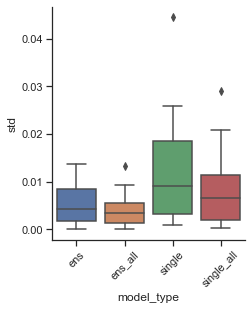

In [10]:
g = sns.catplot(x="model_type", y="std",
                #hue="effect", 
                #col="subarea",
                #order=['single_coder', 'ens_coder', 'single', 'ens'],
                data=df_var, kind="box",
                height=4, aspect=0.9).set_xticklabels(rotation=45);

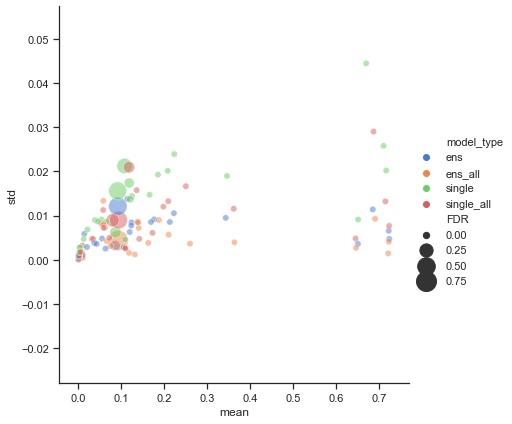

In [11]:
sns.relplot(x="mean", y="std", size="FDR",
            #x="mean", y="FDR",  size="std",
            #x="FDR", y="std",  size="mean",
            hue="model_type", 
            #hue_order= ['single_coder', 'ens_coder', 'single', 'ens'],
            sizes=(40, 400), 
            alpha=.5, palette="muted",
            height=6,aspect=1, data=df_var);

### Per Model Analysis

In [12]:
df_stats = df_long.reset_index().groupby(['subarea','effect', 'type','model_type']).eta.agg(['mean', 'min', 'max', 'std'])
df_model = df_long.reset_index().set_index(['subarea','effect', 'type','model_type']).join(df_stats).reset_index()
df_model['eta_norm'] = np.sqrt((df_model['eta']-df_model['mean'])**2)

df_effect2 = df.join(df_effect, how='left', rsuffix='_ref', on=['subarea', 'type'])
for grp_name in grp_names2:
    df_effect2[grp_name+'_diff'] = df_effect2[grp_name]!=df_effect2[grp_name+'_ref']
df_effect2 = df_effect2.set_index(['subarea','type','model_type','unet'])[grp_names2+'_diff'].unstack([0,1,2,3])
df_effect2.name = 'valid_effect'
df_effect2 = df_effect2.reset_index()
df_effect2['effect'] = df_effect2['level_0'].str[:-5]
df_effect2.drop(['level_0'], axis=1, inplace=True)

df_model = pd.merge(df_effect2, df_model, on=['subarea','type','model_type','unet', 'effect'])

df_model_agg = (df_model.groupby(['model_type','unet']).agg({'eta_norm' : ['std'], 'valid_effect' : ['mean']})).reset_index()
df_model_agg['FDR'] = df_model_agg[('valid_effect', 'mean')] 
df_model_agg['std_norm'] = df_model_agg[('eta_norm','std')]

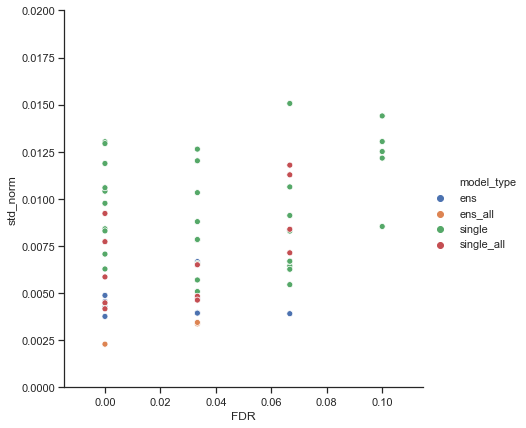

In [13]:
sns.relplot(x="FDR", y="std_norm", # size="mean",
            hue="model_type", 
            #hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            height=6,aspect=1, data=df_model_agg).set(ylim=(0, 0.02));

### F1 Analysis

In [14]:
df_f1 = (df_model.set_index(['unet', 'model_type', 'subarea', 'type'])
         .join(df.set_index(['unet', 'model_type', 'subarea', 'type'])[['f1_score', 'f1_score_test']]))
#df_f1.dropna(inplace=True)
df_f1.reset_index(inplace=True)
df_f1_agg = df_f1.groupby(['model_type','unet', 'type']).agg({'eta_norm' : ['std'], 'valid_effect' : ['mean'], 'f1_score': ['mean'], 'f1_score_test': ['mean']})
df_f1_agg.columns = df_f1_agg.columns.droplevel(1)
df_f1_agg.reset_index(inplace=True)
df_f1_agg = pd.merge(df_f1_agg, df[['unet', 'fold']].drop_duplicates(), how='left', on='unet')
df_f1_agg['log_std'] = np.log(df_f1_agg['eta_norm'])
df_f1_agg['eta_std'] = df_f1_agg['eta_norm']
df_f1_agg.head()

,model_type,unet,type,eta_norm,valid_effect,f1_score,f1_score_test,fold,log_std,eta_std
0,ens,ens_10,norm_cfos_per_area,0.003562,0.000000,NaN,0.770918,e,-5.637306,0.003562
1,ens,ens_10,norm_mean_intensity,0.004071,0.000000,NaN,0.770918,e,-5.503825,0.004071
2,ens,ens_6,norm_cfos_per_area,0.004172,0.000000,NaN,0.776495,e,-5.479273,0.004172
3,ens,ens_6,norm_mean_intensity,0.004363,0.000000,NaN,0.776495,e,-5.434630,0.004363
4,ens,ens_7,norm_cfos_per_area,0.005210,0.066667,NaN,0.771984,e,-5.257092,0.005210


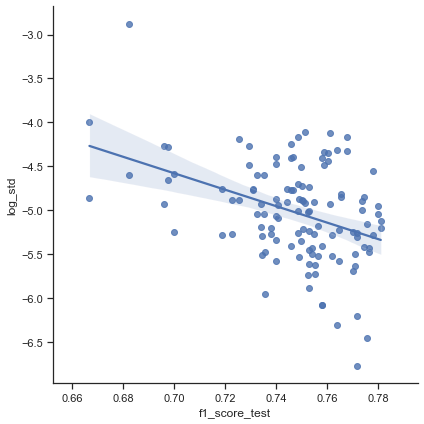

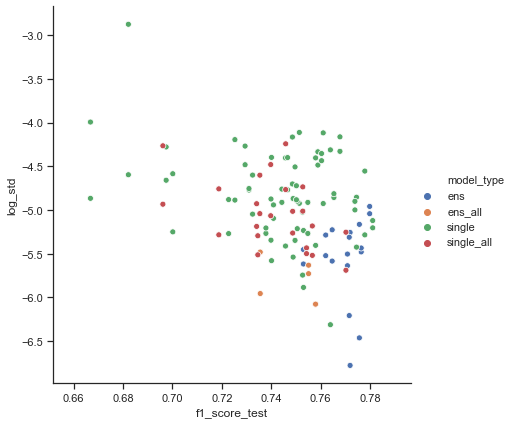

In [15]:
df_plot_rel = df_f1_agg#.loc[df_f1_agg.model_type.isin(['ens', 'single'])]
sns.lmplot(x="f1_score_test", y="log_std", # size="mean",
            height=6,aspect=1, data=df_f1_agg);
sns.relplot(x="f1_score_test", y="log_std", # size="mean",
            hue="model_type",# hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            height=6,aspect=1, data=df_f1_agg);

In [16]:
import statsmodels.api as sm
# Fit and summarize OLS model
mod = sm.OLS(df_plot_rel.log_std, df_f1_agg.f1_score_test)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                log_std   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.099e+04
Date:                Sun, 19 Apr 2020   Prob (F-statistic):                   4.49e-119
Time:                        12:20:59   Log-Likelihood:                         -92.592
No. Observations:                 120   AIC:                                      187.2
Df Residuals:                     119   BIC:                                      190.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

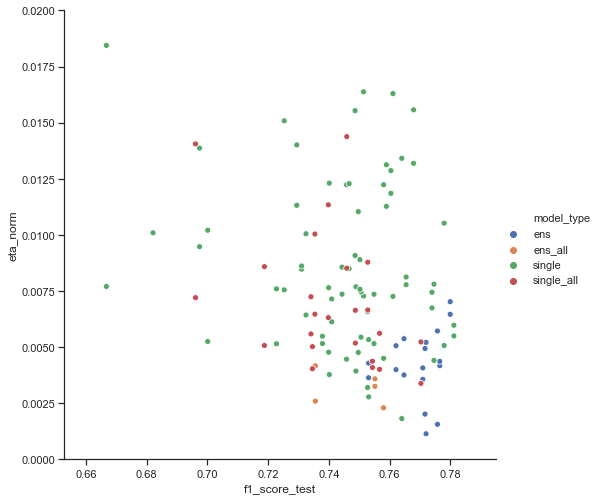

In [47]:
sns.relplot(x="f1_score_test", y="eta_norm", # size="mean",
            hue="model_type",# hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            #alpha=.8, 
            height=7,aspect=1, data=df_f1_agg).set(ylim=(0, 0.02));

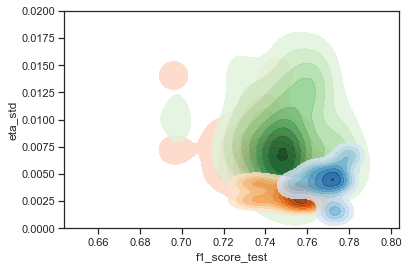

In [50]:
cmaps = ['Reds', 'Greens', 'Oranges', 'Blues']
m_types = ['single_all', 'single', 'ens_all', 'ens']
for m_type, cmap in zip(m_types, cmaps):
    df_kde = df_f1_agg.loc[df_f1_agg.model_type == m_type]
    ax = sns.kdeplot(df_kde.f1_score_test, df_kde.eta_std, 
                     cmap=cmap, shade=True, shade_lowest=False, 
                     alpha=0.8).set(ylim=(0, 0.02));

## Plots

Count

Count
kwa_all


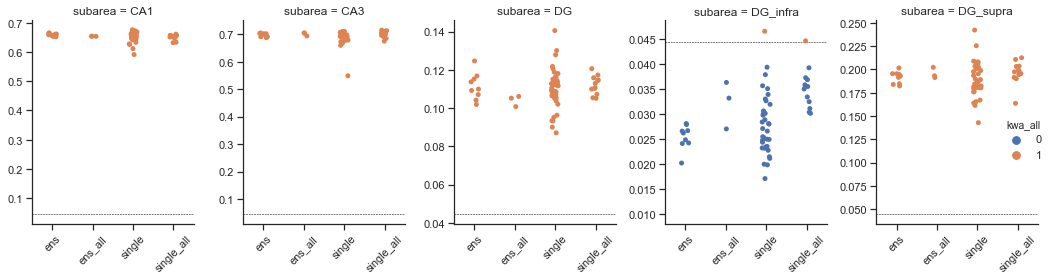

mwu1_vs_2


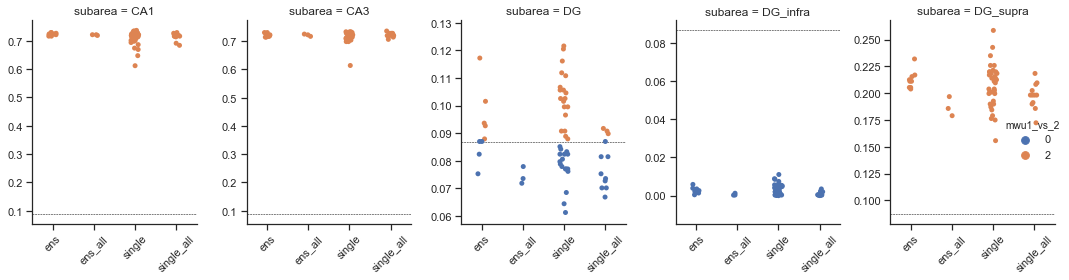

mwu1_vs_3


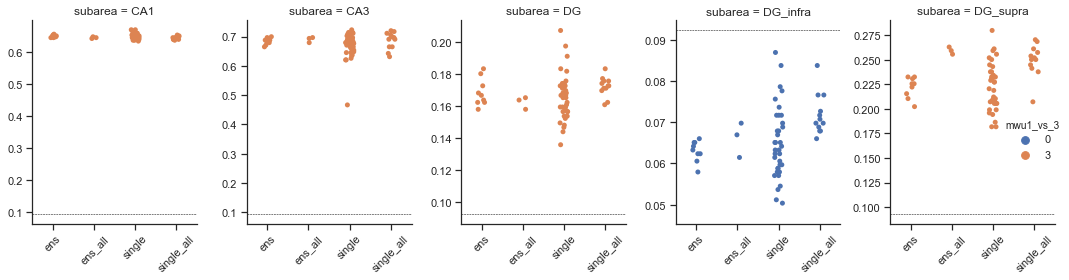

mwu2_vs_3


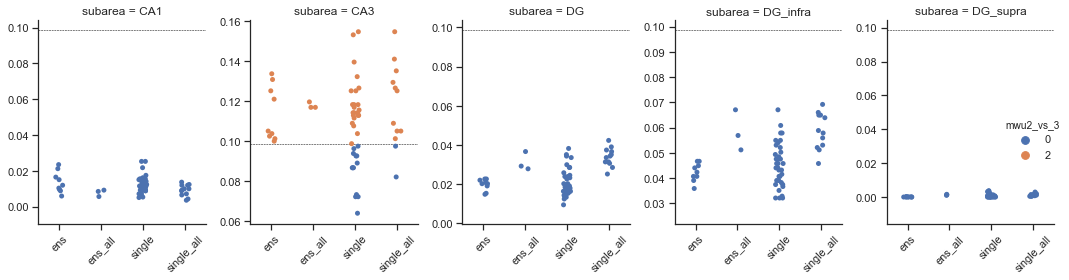

In [36]:
print('Count')
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue=grp_name, col="subarea",#col='init'
                order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_count, kind="strip",dodge=False,legend_out=True,
                height=4, aspect=0.7, sharey=False).set_xticklabels(rotation=45)#.set(ylim=(0, 1))
    c_value = df_count['c_{}'.format(grp_name)]
    g = g.map(plt.axhline, y=c_value.max(), ls='--', c='black', lw=0.5)#xmin=0.2, xmax=0.8,
    plt.show()

Intensity

Intensity
kwa_all


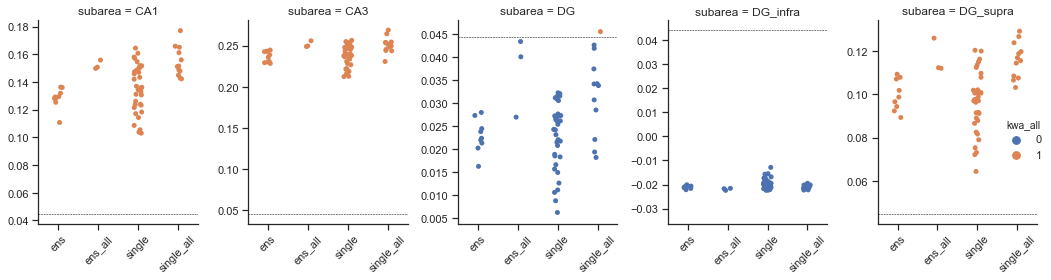

mwu1_vs_2


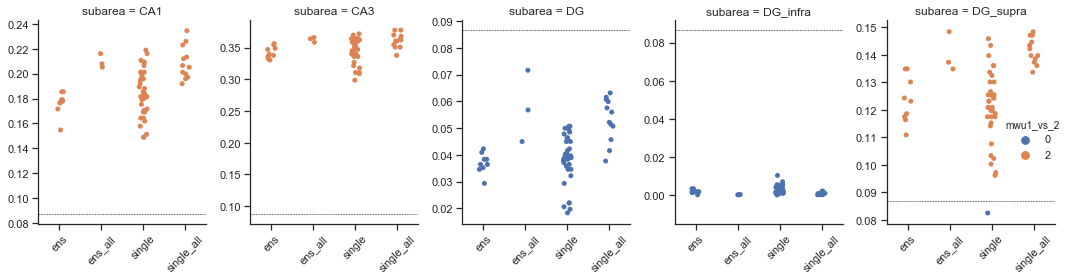

mwu1_vs_3


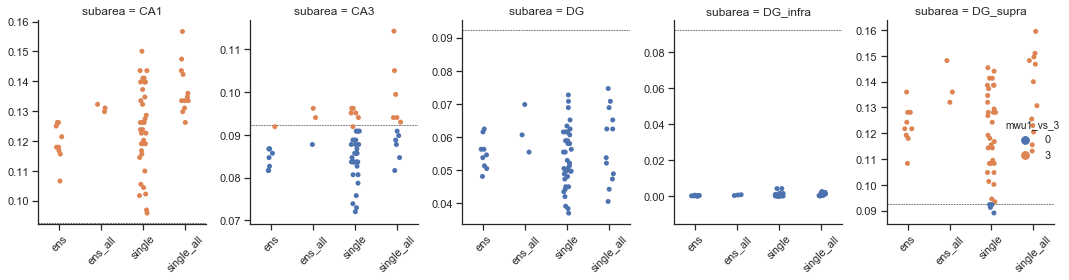

mwu2_vs_3


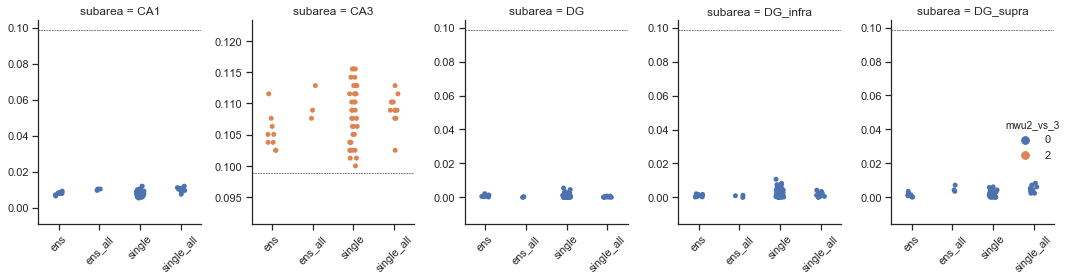

In [37]:
print('Intensity')
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue=grp_name, col="subarea",#col='init'
                order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_int, kind="strip",dodge=False,legend_out=True,
                height=4, aspect=0.7, sharey=False).set_xticklabels(rotation=45)#.set(ylim=(0, 1))
    c_value = df_count['c_{}'.format(grp_name)]
    g = g.map(plt.axhline, y=c_value.max(), ls='--', c='black', lw=0.5)#xmin=0.2, xmax=0.8,
    plt.show()

Coder

In [ ]:
df_coder_count = df_coder[df_coder.type=='norm_cfos_per_area']
df_coder_int = df_coder[df_coder.type=='norm_mean_intensity']

In [ ]:
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue='ens', col="subarea",#col='init'
                data=df_coder_count, kind="strip",dodge=False,
                height=4, aspect=0.75, sharey=False)#.set(ylim=(0, 1))
    c_value = df['c_{}'.format(grp_name)].unique()
    g = g.map(plt.axhline, y=c_value.mean(), xmin=0.2, xmax=0.8, ls='--', c='black', lw=0.5)
    path_fig = os.path.join('_figures',LAB,'effect_strip')
    if not os.path.isdir(path_fig): os.makedirs(path_fig)
    plt.savefig(os.path.join(path_fig,'coder_count_'+grp_name+'.png'))
    plt.show()
    plt.close()

In [ ]:
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue='ens', col="subarea",#col='init'
                data=df_coder_int, kind="strip",dodge=False,
                height=4, aspect=0.75, sharey=False)#.set(ylim=(0, 1))
    c_value = df['c_{}'.format(grp_name)].unique()
    g = g.map(plt.axhline, y=c_value.mean(), xmin=0.2, xmax=0.8, ls='--', c='black', lw=0.5)
    path_fig = os.path.join('_figures',LAB,'effect_strip')
    if not os.path.isdir(path_fig): os.makedirs(path_fig)
    plt.savefig(os.path.join(path_fig,'coder_int_'+grp_name+'.png'))
    plt.show()
    plt.close()

In [ ]:
grp_names = df.columns[df.columns.str.contains('eta^2', regex=False)].str[6:]
for key, grp in df_count.groupby(['subarea']):
    for grp_name in grp_names:
        print(grp_name)
        g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                    hue=grp_name, col="init",
                    data=grp, kind="strip",dodge=False,
                    height=4, aspect=0.75).set(ylim=(0, 1))
        c_value = df['c_{}'.format(grp_name)].unique()
        g = g.map(plt.axhline, y=c_value.mean(), xmin=0.2, xmax=0.8, ls='--', c='black', lw=0.5)
        path_fig = os.path.join('_figures',LAB,'effect_strip')
        if not os.path.isdir(path_fig): os.makedirs(path_fig)
        plt.savefig(os.path.join(path_fig,key+'_'+grp_name+'.png'))
        plt.show()
        plt.close()

In [ ]:
break

In [ ]:
df.head()

In [ ]:
ax = sns.catplot(x='model_type', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="ens2",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

#df['fold'] = df['model'].str.extract(r'fold_(\d{1,})') 
#df['strategy'] = df['unet'].str.extract(r'([a-z]{,2})\d+.?\_[sb]')
#df.groupby('indx').transform(lambda x: (x - x.mean()) / x.std())

create columns

In [ ]:
#df['init'] = df['model'].str[:3]
df['init'] = df['unet'].str[:3]
df['max_epochs'] = df['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df['model_type'] = 'single'
# df.loc[df['unet'].str[-1:]=='e', 'model_type'] = 'ens' 
df.loc[df['init']=='ens', 'model_type'] = 'ens' 
df['fold'] = df['unet'].str.extract(r'\_(\d+)\.') 
df.loc[df['model_type']=='ens', 'fold'] = 'ens' 
df['effect'] = 'no'
df.loc[df['mwu_grp1_vs_2']>0, 'effect'] = 'yes'
df["comb"] = df["init"] + df["max_epochs"]
df['ens2'] = df['ens'].str[4:5]

In [ ]:
df_count = df[df.type=='norm_cfos_per_area']
df_int = df[df.type=='norm_mean_intensity']

In [ ]:
df_count[df_count['ens']=='ens_a1']

In [ ]:
df_count[df_count['ens']=='ens_a2']

In [ ]:
df_count[df_count['ens']=='ens_a3']

In [ ]:
df_count[df_count['ens']=='ens_fsy27']

In [ ]:
col_effects = df.columns.str.startswith('mwu_eta^2')

In [ ]:
col_effects = df.columns.str.startswith('mwu_eta^2')

In [ ]:


ax = sns.catplot(x='model_type', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="ens2",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
ax = sns.catplot(x='model_type', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="ens",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
sns.catplot(x='model_type', y='f1_score',
                hue="effect", col="ens2",
                data=df, kind="strip",
                height=5, aspect=1);

## Without outlier deletion

In [ ]:
ax = sns.catplot(x='model_type', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="ens2",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
ax = sns.catplot(x='model_type', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="ens",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
#df['init'] = df['model'].str[:3]
df['init'] = df['unet'].str[:3]
df['max_epochs'] = df['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df['model_type'] = 'single'
# df.loc[df['unet'].str[-1:]=='e', 'model_type'] = 'ens' 
df.loc[df['init']=='ens', 'model_type'] = 'ens' 
df['fold'] = df['unet'].str.extract(r'\_(\d+)\.') 
df.loc[df['model_type']=='ens', 'fold'] = 'ens' 
df['effect'] = 'no'
df.loc[df['mwu_grp1_vs_2']>0, 'effect'] = 'yes'
df["comb"] = df["init"] + df["max_epochs"]
df['ens2'] = df['ens'].str[4:5]

In [ ]:
df_plot = df#[df['max_epochs'] != "12"]
ax = sns.catplot(x='comb', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="fold",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1);#.set(ylim=(0, 1));

In [ ]:
df_plot = df#[df['max_epochs'] != "12"]
ax = sns.catplot(x='comb', y='mwu_eta^2_grp1_vs_2', 
                hue="effect", col="fold",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1);#.set(ylim=(0, 1));

In [ ]:
df_plot = df#[df['max_epochs'] != "12"]
ax = sns.catplot(x='comb', y='mwu_eta^2_grp1_vs_2',
                hue="model_type", col="lab",
                data=df_count, kind="strip",dodge=True,
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
df_plot = df#[df['max_epochs'] != "12"]
ax = sns.catplot(x='comb', y='mwu_eta^2_grp1_vs_2',
                hue="ensemble", col="lab",
                data=df_count, kind="box",
                height=5, aspect=1).set(ylim=(0, 1));

In [ ]:
df_merge = pd.merge(df, f1_res[['unet','f1_score']], how='left')

In [ ]:
sns.catplot(x='comb', y='f1_score',
                hue="ensemble", col="fold",
                data=df_merge, kind="box",
                height=5, aspect=1);

In [ ]:
ax = sns.stripplot(x="comb", y="mwu_eta^2_grp1_vs_2", hue="fold",
                    data=df_count, palette="Set2", dodge=True)
ax.set_ylim(0,1);

In [ ]:
sns.catplot(x='comb', y='mwu_eta^2_grp1_vs_2',
                hue="fold", col="type",
                data=df_plot, kind="box",
                height=6, aspect=1);

In [ ]:
df.groupby(['type','init','max_epochs', 'ensemble'])['mwu_eta^2_grp1_vs_2'].agg([stats.variation, 'mean', 'std', 'count'])

In [ ]:
sns.boxplot(x='ensemble', y="mwu_eta^2_grp1_vs_2", hue='init', col="type", data=df);

In [ ]:
df.groupby(['type','max_epochs','init', 'fold'])['mwu_eta^2_grp1_vs_2'].agg([stats.variation, 'mean', 'std', 'count'])

In [ ]:
df.groupby(['type','max_epochs','init', 'fold'])['mwu_eta^2_grp1_vs_2'].agg([stats.variation, 'mean', 'std', 'count'])

# Manual

In [ ]:
model = 'pre_staple_fold_10_model_2'
cnn = 'p27b_sc_cyc_inns_01_cFOS_staple_3.0026.h5'

In [ ]:
df_zu = df_zuordnung[(df_zuordnung['name']=='Lucas')&
                    (df_zuordnung['Experiment']=='Test')&
                    (df_zuordnung['Cross-coder Training'].isna()) & 
                    (df_zuordnung['Ausschluss von Analyse'].isna()) &
                    (df_zuordnung['broken'].isna())].copy()

file_ids = df_zu['Nummer'].tolist()
len(file_ids)

## cFOS results

In [ ]:
cfos_list = []
cfos_path = os.path.join(LAB, model, cnn, 'results_cfos')
for fname in [x for x in os.listdir(cfos_path) if not x.startswith('.')]:
    fpath = os.path.join(cfos_path, fname)
    if os.path.getsize(fpath) > 0:
        df_tmp = pd.read_csv(os.path.join(cfos_path, fname))
        cfos_list.append(df_tmp)

df_cfos = pd.concat(cfos_list, ignore_index=True)
df_cfos['Nummer'] = df_cfos.Label.str[:4].astype('int')
df_cfos_agg = df_cfos.groupby('Nummer').Area.agg(['mean', 'count'])
for fid in list(df_cfos_agg.index ^ set(file_ids)):
    df_cfos_agg = df_cfos_agg.append(pd.DataFrame({'mean': np.nan, 'count': 0}, index=[fid]))
    df_cfos_agg.index.name = 'Nummer'

## NeuN Results

In [ ]:
neun_list = []
neun_path = os.path.join(LAB, model, cnn, 'results_neun')
for fname in [x for x in os.listdir(neun_path) if not x.startswith('.')]:
    fpath = os.path.join(neun_path, fname)
    df_tmp = pd.read_csv(os.path.join(neun_path, fname))
    neun_list.append(df_tmp)

df_neun = pd.concat(neun_list, ignore_index=True)
df_neun['Neun_Area'] = df_neun['Area']/1000000    #Area entspricht nun mm²
df_neun['Nummer'] = df_neun.Label.str[:4].astype('int')

In [ ]:
df_res = pd.merge(df_cfos_agg, df_neun[['Nummer','Neun_Area']], on='Nummer')
df_res['cfos_per_area'] = df_res['count']/df_res['Neun_Area']

In [ ]:
df = pd.merge(df_zu, df_res, on='Nummer')

In [ ]:
ctrl_count =  df[df.Kondition == 'Ctrl']['cfos_per_area'].mean()
ctrl_intensity = df[df.Kondition == 'Ctrl']['mean'].mean()

In [ ]:
df['norm_cfos_per_area'] = df['cfos_per_area']/ctrl_count
df['norm_mean_intensity'] = df['mean']/ctrl_intensity

In [ ]:
df

## Statistical Evaluation

In [ ]:
count_list = []
intensity_list = []

In [ ]:
np.array([*grp_norms,levene])

In [ ]:
#2 groups

In [ ]:
for m in ['norm_cfos_per_area', 'norm_mean_intensity']:
    if all(df.groupby('Kondition').size()>0):
        grp_data = [x[1].dropna() for x in df.groupby('Kondition')[m]]
        grp_means = [x.mean() for x in grp_data]        
        # Perform the Shapiro-Wilk test for normality.
        _, grp_norms = map(stats.shapiro, grp_data)
        #Check for equality of variances
        _, levene = stats.levene(*grp_data)

        anova = False
        # Conditions for ANOVA
        if all(np.array([*grp_norms,levene])> 0.05):
            anova = True
            aov = pg.anova(dv=m, between='Kondition', data=df, detailed=False)
            eta_squared = aov['np2'][0]
            p_value = aov['p-unc'][0] 

        else:
            U, p_value = stats.mannwhitneyu(*grp_data, alternative = 'two-sided')
            n_1 = grp_data[0].count()
            n_2 = grp_data[1].count()
            N = n_1 + n_2
            eta_squared = ((U - (n_1*n_2/2)) / np.sqrt((n_1*n_2*(n_1+n_2+1))/12) / np.sqrt(n_1+n_2))**2
            # according to http://www.statisticslectures.com/topics/mannwhitneyu/ & cross-checked with Origin & psychometrica

        grp1_vs_2 = 0     
        if (p_value <= 0.05) & (grp_means[0] != grp_means[1]):
            grp1_vs_2 = 1 if (grp_means[0] > grp_means[1]) else 2 

    else: 
        eta_squared, p_value = np.nan, np.nan

    df_temp = pd.DataFrame({'model': [model],
                             'eta^2': [eta_squared],
                             'grp1_vs_2': [grp1_vs_2],
                             'p_grp1_vs_2': [p_value],
                             'Anova': [anova]})
    if m == 'norm_cfos_per_area':
        count_list += [df_temp]
    else:
        intensity_list += [df_temp]